In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='500'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
INPUT_PT_PATH = f"/workspace/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233/density_plot.png


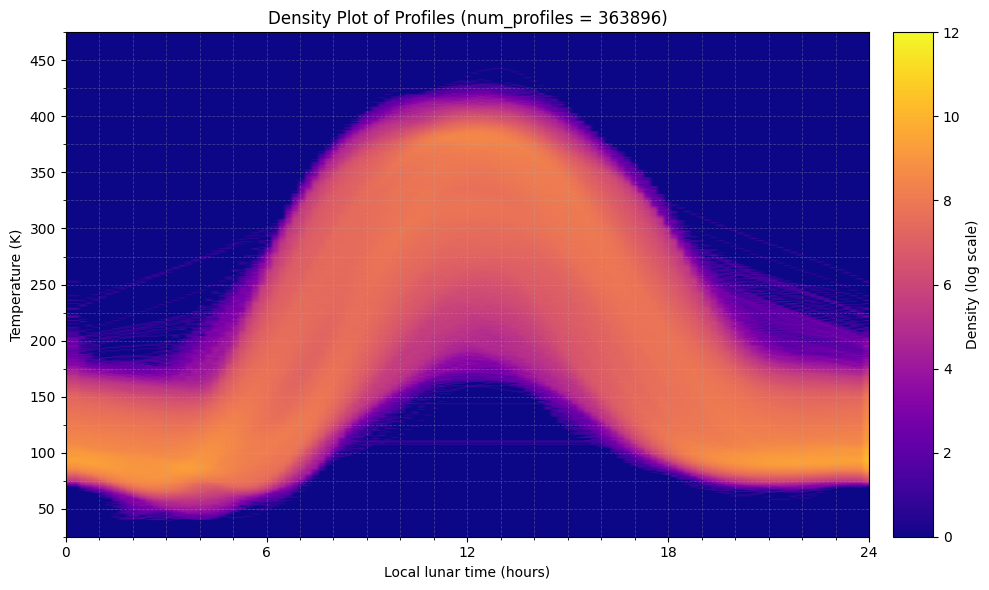

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 191.7485
STD: 97.1937
Min Temp: 40.0240
Max Temp: 442.1840
Datasets:
Training Data: 254727
Validation Data: 72779
Test Data: 36390


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.59it/s, best_loss=0.5462]


[Training] Epoch 1/100, L1 Loss: 0.5950, L2 Loss: 0.5857, KL Loss: 0.5710, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 364/364 [00:03<00:00, 98.26it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5132, Val KL Loss: 0.6022
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233'


[Training] Epoch 2/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.47it/s, best_loss=0.5763]


[Training] Epoch 2/100, L1 Loss: 0.5747, L2 Loss: 0.5567, KL Loss: 0.6038, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 364/364 [00:03<00:00, 98.39it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5120, Val KL Loss: 0.5979
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233'


[Training] Epoch 3/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.27it/s, best_loss=0.5550]


[Training] Epoch 3/100, L1 Loss: 0.5741, L2 Loss: 0.5557, KL Loss: 0.6040, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 364/364 [00:03<00:00, 100.64it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5296, Val L2 Loss: 0.5111, Val KL Loss: 0.6076
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233'


[Training] Epoch 4/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.09it/s, best_loss=0.5774]


[Training] Epoch 4/100, L1 Loss: 0.5741, L2 Loss: 0.5557, KL Loss: 0.6030, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 364/364 [00:03<00:00, 106.67it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5117, Val KL Loss: 0.6027


[Training] Epoch 5/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.76it/s, best_loss=0.5686]


[Training] Epoch 5/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 364/364 [00:03<00:00, 91.02it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5116, Val KL Loss: 0.6024


[Training] Epoch 6/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.91it/s, best_loss=0.5795]


[Training] Epoch 6/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 364/364 [00:03<00:00, 94.58it/s] 


[Validation] Epoch 6/100, Val L1 Loss: 0.5352, Val L2 Loss: 0.5152, Val KL Loss: 0.5931


[Training] Epoch 7/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.50it/s, best_loss=0.5856]


[Training] Epoch 7/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 364/364 [00:03<00:00, 96.34it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5340, Val L2 Loss: 0.5144, Val KL Loss: 0.5899


[Training] Epoch 8/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.61it/s, best_loss=0.5752]


[Training] Epoch 8/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 364/364 [00:03<00:00, 94.95it/s] 


[Validation] Epoch 8/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5119, Val KL Loss: 0.6005


[Training] Epoch 9/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.05it/s, best_loss=0.5685]


[Training] Epoch 9/100, L1 Loss: 0.5744, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 364/364 [00:03<00:00, 95.91it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5110, Val KL Loss: 0.6053
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233'


[Training] Epoch 10/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.22it/s, best_loss=0.5616]


[Training] Epoch 10/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 364/364 [00:03<00:00, 100.74it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5102, Val KL Loss: 0.6067
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_500_20250720_2233'


[Training] Epoch 11/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.08it/s, best_loss=0.5881]


[Training] Epoch 11/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 364/364 [00:03<00:00, 103.10it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5124, Val KL Loss: 0.5976


[Training] Epoch 12/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.07it/s, best_loss=0.5697]


[Training] Epoch 12/100, L1 Loss: 0.5740, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 364/364 [00:03<00:00, 100.68it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5121, Val KL Loss: 0.5987


[Training] Epoch 13/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.20it/s, best_loss=0.5692]


[Training] Epoch 13/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 364/364 [00:03<00:00, 96.67it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5116, Val KL Loss: 0.6034


[Training] Epoch 14/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.33it/s, best_loss=0.5844]


[Training] Epoch 14/100, L1 Loss: 0.5741, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 364/364 [00:03<00:00, 101.00it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5116, Val KL Loss: 0.6042


[Training] Epoch 15/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.12it/s, best_loss=0.5583]


[Training] Epoch 15/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 364/364 [00:03<00:00, 94.39it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5321, Val L2 Loss: 0.5130, Val KL Loss: 0.5994


[Training] Epoch 16/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.96it/s, best_loss=0.5705]


[Training] Epoch 16/100, L1 Loss: 0.5739, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 364/364 [00:03<00:00, 100.13it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5119, Val KL Loss: 0.6000


[Training] Epoch 17/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.23it/s, best_loss=0.5720]


[Training] Epoch 17/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 364/364 [00:03<00:00, 92.68it/s] 


[Validation] Epoch 17/100, Val L1 Loss: 0.5347, Val L2 Loss: 0.5149, Val KL Loss: 0.5964


[Training] Epoch 18/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.74it/s, best_loss=0.5539]


[Training] Epoch 18/100, L1 Loss: 0.5744, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 364/364 [00:04<00:00, 89.97it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5122, Val KL Loss: 0.6001


[Training] Epoch 19/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.35it/s, best_loss=0.5866]


[Training] Epoch 19/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 364/364 [00:03<00:00, 99.25it/s] 


[Validation] Epoch 19/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5111, Val KL Loss: 0.6061


[Training] Epoch 20/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.37it/s, best_loss=0.5622]


[Training] Epoch 20/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6029, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 364/364 [00:03<00:00, 100.80it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5109, Val KL Loss: 0.6048


[Training] Epoch 21/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.30it/s, best_loss=0.5757]


[Training] Epoch 21/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 364/364 [00:03<00:00, 93.13it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5125, Val KL Loss: 0.5980


[Training] Epoch 22/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.06it/s, best_loss=0.5700]


[Training] Epoch 22/100, L1 Loss: 0.5742, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 364/364 [00:03<00:00, 96.73it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5122, Val KL Loss: 0.5994


[Training] Epoch 23/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.66it/s, best_loss=0.5816]


[Training] Epoch 23/100, L1 Loss: 0.5743, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 364/364 [00:03<00:00, 106.33it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5128, Val KL Loss: 0.5979


[Training] Epoch 24/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.36it/s, best_loss=0.5724]


[Training] Epoch 24/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 364/364 [00:03<00:00, 96.78it/s] 


[Validation] Epoch 24/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5130, Val KL Loss: 0.5965


[Training] Epoch 25/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.09it/s, best_loss=0.5693]


[Training] Epoch 25/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 364/364 [00:03<00:00, 100.11it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5129, Val KL Loss: 0.5971


[Training] Epoch 26/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.99it/s, best_loss=0.5687]


[Training] Epoch 26/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 364/364 [00:03<00:00, 103.38it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5145, Val KL Loss: 0.5968


[Training] Epoch 27/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.90it/s, best_loss=0.5752]


[Training] Epoch 27/100, L1 Loss: 0.5740, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 364/364 [00:03<00:00, 94.25it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5120, Val KL Loss: 0.6013


[Training] Epoch 28/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.18it/s, best_loss=0.5845]


[Training] Epoch 28/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 364/364 [00:03<00:00, 96.48it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5104, Val KL Loss: 0.6041


[Training] Epoch 29/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.72it/s, best_loss=0.5552]


[Training] Epoch 29/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6029, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 364/364 [00:04<00:00, 88.62it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5115, Val KL Loss: 0.6038


[Training] Epoch 30/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.10it/s, best_loss=0.5814]


[Training] Epoch 30/100, L1 Loss: 0.5742, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 364/364 [00:03<00:00, 94.49it/s] 


[Validation] Epoch 30/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5122, Val KL Loss: 0.5978


[Training] Epoch 31/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.97it/s, best_loss=0.5715]


[Training] Epoch 31/100, L1 Loss: 0.5740, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 364/364 [00:03<00:00, 97.07it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.5322, Val L2 Loss: 0.5130, Val KL Loss: 0.6006


[Training] Epoch 32/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.95it/s, best_loss=0.5773]


[Training] Epoch 32/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 364/364 [00:03<00:00, 95.98it/s] 


[Validation] Epoch 32/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5112, Val KL Loss: 0.6061


[Training] Epoch 33/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.14it/s, best_loss=0.5585]


[Training] Epoch 33/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 364/364 [00:03<00:00, 92.41it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5144, Val KL Loss: 0.5956


[Training] Epoch 34/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.30it/s, best_loss=0.5658]


[Training] Epoch 34/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 364/364 [00:03<00:00, 97.66it/s] 


[Validation] Epoch 34/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5119, Val KL Loss: 0.5985


[Training] Epoch 35/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.66it/s, best_loss=0.5740]


[Training] Epoch 35/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 364/364 [00:03<00:00, 93.91it/s] 


[Validation] Epoch 35/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5132, Val KL Loss: 0.5939


[Training] Epoch 36/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.87it/s, best_loss=0.5734]


[Training] Epoch 36/100, L1 Loss: 0.5740, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 364/364 [00:03<00:00, 99.72it/s] 


[Validation] Epoch 36/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5126, Val KL Loss: 0.6006


[Training] Epoch 37/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.83it/s, best_loss=0.5832]


[Training] Epoch 37/100, L1 Loss: 0.5743, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 364/364 [00:03<00:00, 94.34it/s] 


[Validation] Epoch 37/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5106, Val KL Loss: 0.6062


[Training] Epoch 38/100: 100%|██████████| 1274/1274 [00:43<00:00, 29.60it/s, best_loss=0.5498]


[Training] Epoch 38/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 364/364 [00:03<00:00, 108.12it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5120, Val KL Loss: 0.6011


[Training] Epoch 39/100: 100%|██████████| 1274/1274 [00:39<00:00, 32.36it/s, best_loss=0.5893]


[Training] Epoch 39/100, L1 Loss: 0.5744, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 364/364 [00:03<00:00, 94.42it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5108, Val KL Loss: 0.6028


[Training] Epoch 40/100: 100%|██████████| 1274/1274 [00:41<00:00, 30.55it/s, best_loss=0.5684]


[Training] Epoch 40/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 364/364 [00:03<00:00, 98.56it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5147, Val KL Loss: 0.5919


[Training] Epoch 41/100: 100%|██████████| 1274/1274 [00:42<00:00, 30.29it/s, best_loss=0.5847]


[Training] Epoch 41/100, L1 Loss: 0.5738, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 364/364 [00:03<00:00, 98.08it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5111, Val KL Loss: 0.6031


[Training] Epoch 42/100: 100%|██████████| 1274/1274 [00:44<00:00, 28.75it/s, best_loss=0.5782]


[Training] Epoch 42/100, L1 Loss: 0.5741, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 364/364 [00:03<00:00, 95.83it/s] 


[Validation] Epoch 42/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5141, Val KL Loss: 0.5992


[Training] Epoch 43/100: 100%|██████████| 1274/1274 [00:42<00:00, 29.64it/s, best_loss=0.5672]


[Training] Epoch 43/100, L1 Loss: 0.5738, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 364/364 [00:03<00:00, 95.72it/s] 


[Validation] Epoch 43/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5117, Val KL Loss: 0.6035


[Training] Epoch 44/100: 100%|██████████| 1274/1274 [00:43<00:00, 29.01it/s, best_loss=0.5828]


[Training] Epoch 44/100, L1 Loss: 0.5742, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 364/364 [00:03<00:00, 93.47it/s] 


[Validation] Epoch 44/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5107, Val KL Loss: 0.6085


[Training] Epoch 45/100: 100%|██████████| 1274/1274 [00:43<00:00, 29.20it/s, best_loss=0.5677]


[Training] Epoch 45/100, L1 Loss: 0.5740, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 364/364 [00:03<00:00, 96.47it/s] 


[Validation] Epoch 45/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5132, Val KL Loss: 0.5984


[Training] Epoch 46/100: 100%|██████████| 1274/1274 [00:43<00:00, 29.01it/s, best_loss=0.5639]


[Training] Epoch 46/100, L1 Loss: 0.5743, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 364/364 [00:03<00:00, 100.68it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5124, Val KL Loss: 0.6006


[Training] Epoch 47/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.16it/s, best_loss=0.5807]


[Training] Epoch 47/100, L1 Loss: 0.5741, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 364/364 [00:04<00:00, 89.45it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5120, Val KL Loss: 0.6012


[Training] Epoch 48/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.06it/s, best_loss=0.5712]


[Training] Epoch 48/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 364/364 [00:04<00:00, 88.94it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5125, Val KL Loss: 0.5988


[Training] Epoch 49/100: 100%|██████████| 1274/1274 [00:44<00:00, 28.62it/s, best_loss=0.5616]


[Training] Epoch 49/100, L1 Loss: 0.5744, L2 Loss: 0.5562, KL Loss: 0.6027, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 364/364 [00:04<00:00, 90.13it/s] 


[Validation] Epoch 49/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5111, Val KL Loss: 0.6052


[Training] Epoch 50/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.19it/s, best_loss=0.5770]


[Training] Epoch 50/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 364/364 [00:03<00:00, 94.53it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5137, Val KL Loss: 0.5968


[Training] Epoch 51/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.89it/s, best_loss=0.5742]


[Training] Epoch 51/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 364/364 [00:03<00:00, 95.07it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5103, Val KL Loss: 0.6103


[Training] Epoch 52/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.70it/s, best_loss=0.5786]


[Training] Epoch 52/100, L1 Loss: 0.5739, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 364/364 [00:03<00:00, 99.58it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5103, Val KL Loss: 0.6067


[Training] Epoch 53/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.21it/s, best_loss=0.5609]


[Training] Epoch 53/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 364/364 [00:04<00:00, 88.24it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5133, Val KL Loss: 0.5968


[Training] Epoch 54/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.16it/s, best_loss=0.5618]


[Training] Epoch 54/100, L1 Loss: 0.5740, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 364/364 [00:03<00:00, 101.38it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5321, Val L2 Loss: 0.5129, Val KL Loss: 0.6022


[Training] Epoch 55/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.19it/s, best_loss=0.5716]


[Training] Epoch 55/100, L1 Loss: 0.5743, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 364/364 [00:03<00:00, 92.21it/s] 


[Validation] Epoch 55/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5142, Val KL Loss: 0.5938


[Training] Epoch 56/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.72it/s, best_loss=0.5689]


[Training] Epoch 56/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 364/364 [00:03<00:00, 91.37it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5112, Val KL Loss: 0.6032


[Training] Epoch 57/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.07it/s, best_loss=0.5772]


[Training] Epoch 57/100, L1 Loss: 0.5743, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 364/364 [00:03<00:00, 96.70it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5123, Val KL Loss: 0.5988


[Training] Epoch 58/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.86it/s, best_loss=0.5769]


[Training] Epoch 58/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 364/364 [00:03<00:00, 91.27it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5115, Val KL Loss: 0.6003


[Training] Epoch 59/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.89it/s, best_loss=0.5751]


[Training] Epoch 59/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 364/364 [00:03<00:00, 91.24it/s] 


[Validation] Epoch 59/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5116, Val KL Loss: 0.5988


[Training] Epoch 60/100: 100%|██████████| 1274/1274 [00:44<00:00, 28.37it/s, best_loss=0.5849]


[Training] Epoch 60/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 364/364 [00:03<00:00, 97.90it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5143, Val KL Loss: 0.5939


[Training] Epoch 61/100: 100%|██████████| 1274/1274 [00:44<00:00, 28.35it/s, best_loss=0.5591]


[Training] Epoch 61/100, L1 Loss: 0.5739, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 364/364 [00:03<00:00, 93.79it/s] 


[Validation] Epoch 61/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5130, Val KL Loss: 0.5969


[Training] Epoch 62/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.01it/s, best_loss=0.5711]


[Training] Epoch 62/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 364/364 [00:03<00:00, 94.21it/s] 


[Validation] Epoch 62/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5118, Val KL Loss: 0.6046


[Training] Epoch 63/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.85it/s, best_loss=0.5712]


[Training] Epoch 63/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 364/364 [00:03<00:00, 93.48it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5132, Val KL Loss: 0.5999


[Training] Epoch 64/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.26it/s, best_loss=0.5808]


[Training] Epoch 64/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 364/364 [00:03<00:00, 94.50it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5116, Val KL Loss: 0.6048


[Training] Epoch 65/100: 100%|██████████| 1274/1274 [00:45<00:00, 28.12it/s, best_loss=0.5854]


[Training] Epoch 65/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 364/364 [00:03<00:00, 93.17it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5112, Val KL Loss: 0.6063


[Training] Epoch 66/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.60it/s, best_loss=0.5663]


[Training] Epoch 66/100, L1 Loss: 0.5742, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 364/364 [00:04<00:00, 89.25it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5115, Val KL Loss: 0.6044


[Training] Epoch 67/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.71it/s, best_loss=0.5504]


[Training] Epoch 67/100, L1 Loss: 0.5740, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 364/364 [00:04<00:00, 87.60it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5323, Val L2 Loss: 0.5131, Val KL Loss: 0.5944


[Training] Epoch 68/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.66it/s, best_loss=0.5656]


[Training] Epoch 68/100, L1 Loss: 0.5739, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 364/364 [00:04<00:00, 87.46it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5132, Val KL Loss: 0.5977


[Training] Epoch 69/100: 100%|██████████| 1274/1274 [00:45<00:00, 27.76it/s, best_loss=0.5644]


[Training] Epoch 69/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 364/364 [00:04<00:00, 90.56it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5119, Val KL Loss: 0.6031


[Training] Epoch 70/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.88it/s, best_loss=0.5650]


[Training] Epoch 70/100, L1 Loss: 0.5739, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 364/364 [00:04<00:00, 90.95it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5172, Val KL Loss: 0.5905


[Training] Epoch 71/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.96it/s, best_loss=0.5559]


[Training] Epoch 71/100, L1 Loss: 0.5741, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 364/364 [00:04<00:00, 89.67it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5121, Val KL Loss: 0.6014


[Training] Epoch 72/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.87it/s, best_loss=0.5746]


[Training] Epoch 72/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 364/364 [00:04<00:00, 87.09it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5133, Val KL Loss: 0.5978


[Training] Epoch 73/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.81it/s, best_loss=0.5655]


[Training] Epoch 73/100, L1 Loss: 0.5739, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 364/364 [00:04<00:00, 84.07it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5135, Val KL Loss: 0.5975


[Training] Epoch 74/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.88it/s, best_loss=0.5701]


[Training] Epoch 74/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 364/364 [00:04<00:00, 88.85it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5118, Val KL Loss: 0.6011


[Training] Epoch 75/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.67it/s, best_loss=0.5703]


[Training] Epoch 75/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 364/364 [00:04<00:00, 88.18it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5134, Val KL Loss: 0.5951


[Training] Epoch 76/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.74it/s, best_loss=0.5741]


[Training] Epoch 76/100, L1 Loss: 0.5740, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 364/364 [00:03<00:00, 92.66it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5109, Val KL Loss: 0.6043


[Training] Epoch 77/100: 100%|██████████| 1274/1274 [00:49<00:00, 25.68it/s, best_loss=0.5422]


[Training] Epoch 77/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 364/364 [00:04<00:00, 89.73it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5117, Val KL Loss: 0.6046


[Training] Epoch 78/100: 100%|██████████| 1274/1274 [00:47<00:00, 27.07it/s, best_loss=0.5745]


[Training] Epoch 78/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 364/364 [00:04<00:00, 89.09it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5345, Val L2 Loss: 0.5147, Val KL Loss: 0.5914


[Training] Epoch 79/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.88it/s, best_loss=0.5593]


[Training] Epoch 79/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 364/364 [00:04<00:00, 87.19it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5130, Val KL Loss: 0.5973


[Training] Epoch 80/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.90it/s, best_loss=0.5673]


[Training] Epoch 80/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 364/364 [00:04<00:00, 85.01it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5123, Val KL Loss: 0.5974


[Training] Epoch 81/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.89it/s, best_loss=0.5628]


[Training] Epoch 81/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 364/364 [00:03<00:00, 98.65it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5119, Val KL Loss: 0.6021


[Training] Epoch 82/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.39it/s, best_loss=0.5666]


[Training] Epoch 82/100, L1 Loss: 0.5742, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 364/364 [00:03<00:00, 98.61it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5129, Val KL Loss: 0.6001


[Training] Epoch 83/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.51it/s, best_loss=0.5616]


[Training] Epoch 83/100, L1 Loss: 0.5743, L2 Loss: 0.5562, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 364/364 [00:03<00:00, 94.35it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5125, Val KL Loss: 0.6019


[Training] Epoch 84/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.48it/s, best_loss=0.5799]


[Training] Epoch 84/100, L1 Loss: 0.5739, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 364/364 [00:03<00:00, 94.71it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5319, Val L2 Loss: 0.5128, Val KL Loss: 0.6018


[Training] Epoch 85/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.35it/s, best_loss=0.5654]


[Training] Epoch 85/100, L1 Loss: 0.5740, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 364/364 [00:03<00:00, 95.68it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5121, Val KL Loss: 0.6010


[Training] Epoch 86/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.19it/s, best_loss=0.5514]


[Training] Epoch 86/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 364/364 [00:03<00:00, 93.84it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5132, Val KL Loss: 0.5972


[Training] Epoch 87/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.73it/s, best_loss=0.5703]


[Training] Epoch 87/100, L1 Loss: 0.5742, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 364/364 [00:03<00:00, 95.10it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5331, Val L2 Loss: 0.5138, Val KL Loss: 0.5970


[Training] Epoch 88/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.87it/s, best_loss=0.5851]


[Training] Epoch 88/100, L1 Loss: 0.5744, L2 Loss: 0.5564, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 364/364 [00:03<00:00, 93.33it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5114, Val KL Loss: 0.6053


[Training] Epoch 89/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.69it/s, best_loss=0.5598]


[Training] Epoch 89/100, L1 Loss: 0.5743, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 364/364 [00:03<00:00, 91.89it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5128, Val KL Loss: 0.6035


[Training] Epoch 90/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.58it/s, best_loss=0.5795]


[Training] Epoch 90/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 364/364 [00:03<00:00, 96.60it/s] 


[Validation] Epoch 90/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5112, Val KL Loss: 0.6040


[Training] Epoch 91/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.73it/s, best_loss=0.5585]


[Training] Epoch 91/100, L1 Loss: 0.5743, L2 Loss: 0.5561, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 364/364 [00:03<00:00, 92.43it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5306, Val L2 Loss: 0.5119, Val KL Loss: 0.6008


[Training] Epoch 92/100: 100%|██████████| 1274/1274 [00:47<00:00, 26.95it/s, best_loss=0.5832]


[Training] Epoch 92/100, L1 Loss: 0.5739, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 364/364 [00:03<00:00, 94.93it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5115, Val KL Loss: 0.6025


[Training] Epoch 93/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.12it/s, best_loss=0.5700]


[Training] Epoch 93/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 364/364 [00:03<00:00, 94.85it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5286, Val L2 Loss: 0.5104, Val KL Loss: 0.6065


[Training] Epoch 94/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.33it/s, best_loss=0.5587]


[Training] Epoch 94/100, L1 Loss: 0.5740, L2 Loss: 0.5557, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 364/364 [00:03<00:00, 95.58it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5128, Val KL Loss: 0.5994


[Training] Epoch 95/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.29it/s, best_loss=0.5497]


[Training] Epoch 95/100, L1 Loss: 0.5740, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 364/364 [00:03<00:00, 95.12it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5325, Val L2 Loss: 0.5132, Val KL Loss: 0.5999


[Training] Epoch 96/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.19it/s, best_loss=0.5822]


[Training] Epoch 96/100, L1 Loss: 0.5738, L2 Loss: 0.5556, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 364/364 [00:03<00:00, 96.35it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.5330, Val L2 Loss: 0.5136, Val KL Loss: 0.5967


[Training] Epoch 97/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.25it/s, best_loss=0.5746]


[Training] Epoch 97/100, L1 Loss: 0.5741, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 364/364 [00:03<00:00, 93.75it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5327, Val L2 Loss: 0.5134, Val KL Loss: 0.5982


[Training] Epoch 98/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.16it/s, best_loss=0.5739]


[Training] Epoch 98/100, L1 Loss: 0.5741, L2 Loss: 0.5560, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 364/364 [00:03<00:00, 93.24it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5126, Val KL Loss: 0.5995


[Training] Epoch 99/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.23it/s, best_loss=0.5663]


[Training] Epoch 99/100, L1 Loss: 0.5743, L2 Loss: 0.5559, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 364/364 [00:03<00:00, 96.01it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5143, Val KL Loss: 0.5921


[Training] Epoch 100/100: 100%|██████████| 1274/1274 [00:46<00:00, 27.19it/s, best_loss=0.5717]


[Training] Epoch 100/100, L1 Loss: 0.5741, L2 Loss: 0.5558, KL Loss: 0.6028, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 364/364 [00:03<00:00, 95.77it/s] 


[Validation] Epoch 100/100, Val L1 Loss: 0.5314, Val L2 Loss: 0.5127, Val KL Loss: 0.6006


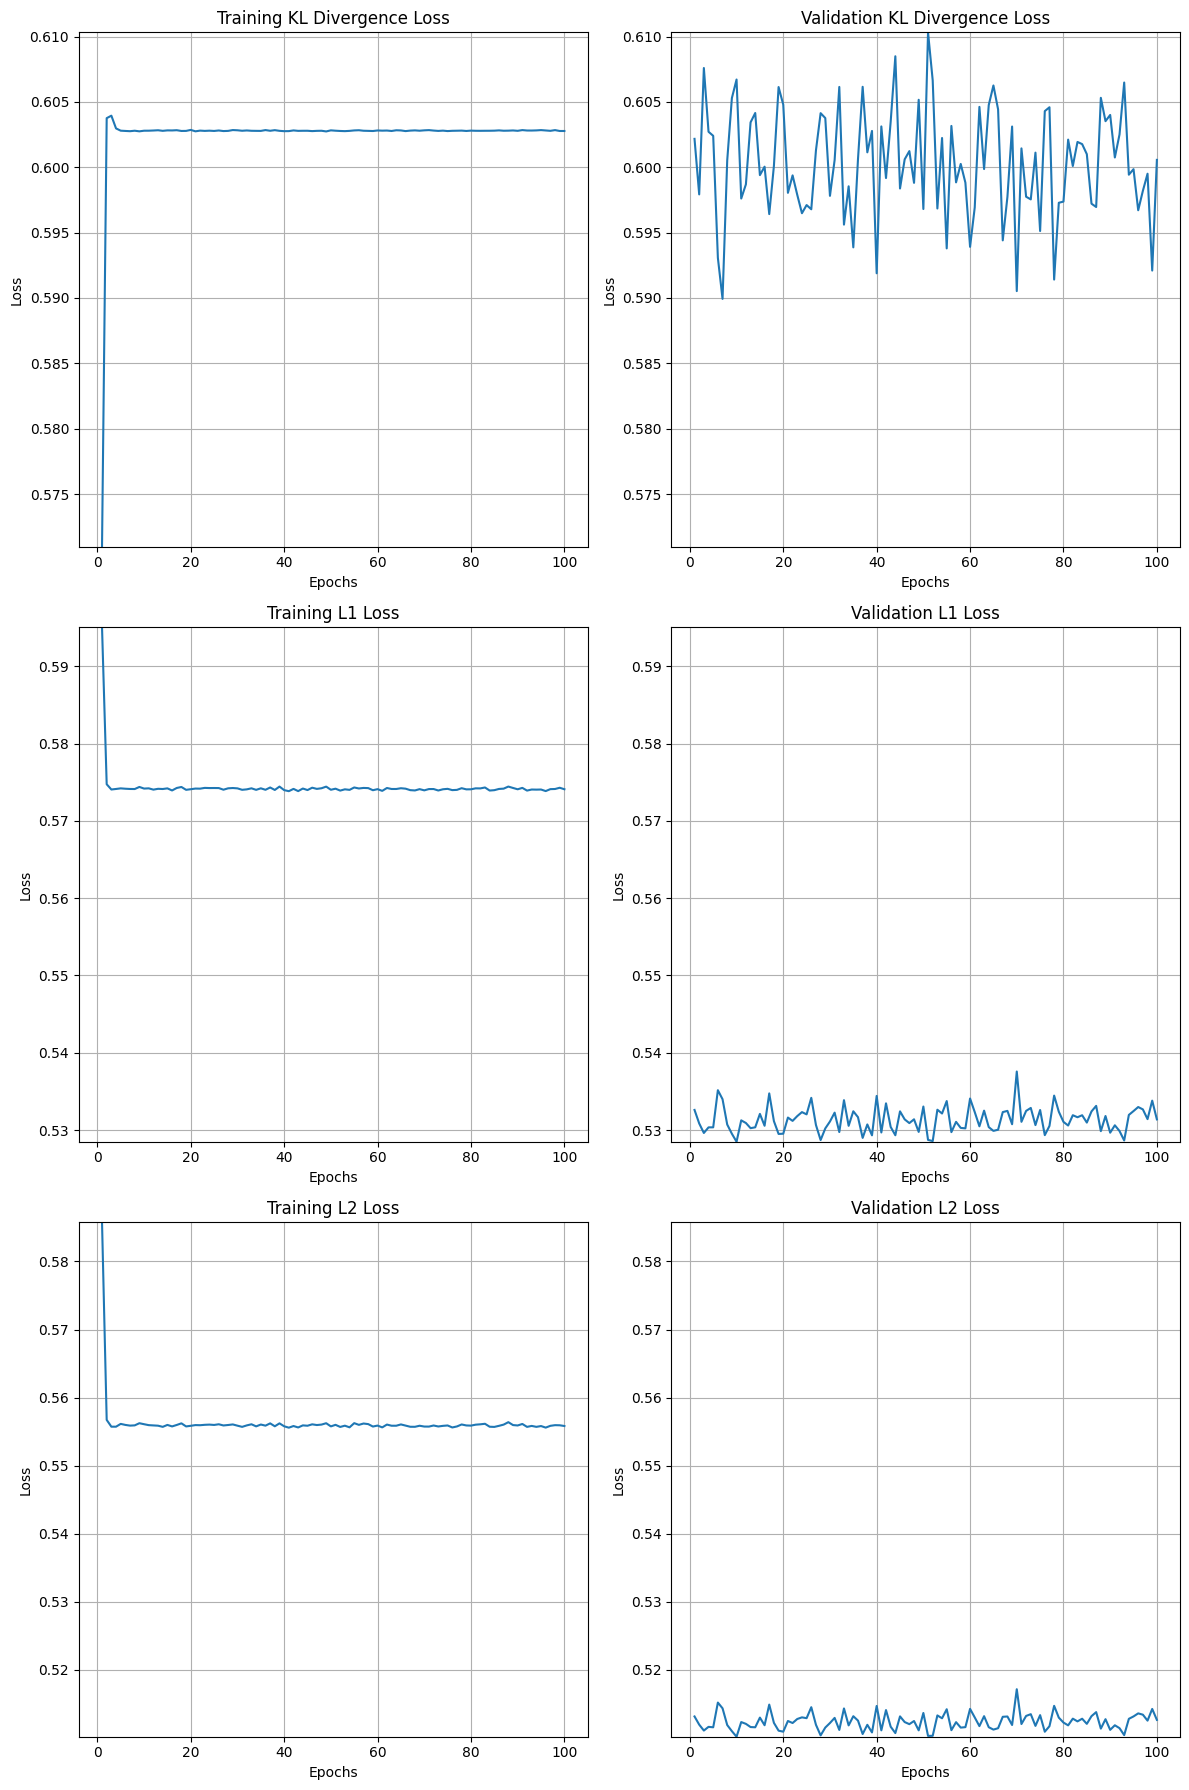

Best Validation Loss in Kelvins:
51.3657 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


z0: -0.0009
z1: -0.0012
z2: -0.0377
z3: 0.0029


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 663.82it/s]


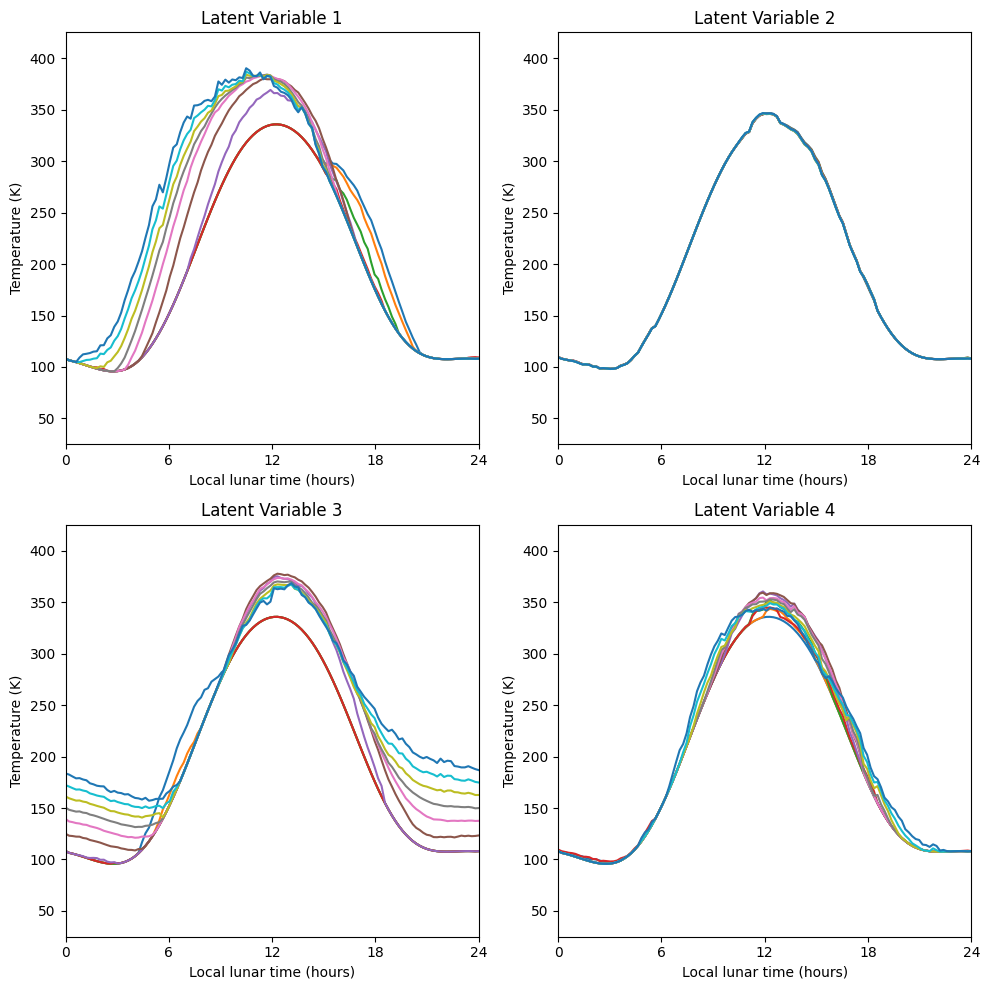

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)